## Win/Loss Betting Model


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data = pd.read_csv('data.csv', index_col=0).reset_index(drop=True)

In [2]:
teams = np.sort(np.unique(np.concatenate([data['Team 1 ID'], data['Team 2 ID']])))
periods = data.Date.unique()
tmap = {v:k for k,v in dict(enumerate(teams)).items()}
pmap = {v:k for k,v in dict(enumerate(periods)).items()}
n_teams = len(teams)
n_periods = len(periods)
print('Number of Teams: %i ' % n_teams)
print('Number of Matches: %i ' % len(data))
print('Number of Periods: %i '% n_periods)

Number of Teams: 288 
Number of Matches: 5757 
Number of Periods: 6 


## Pymc Model

Determining Binary Win Loss: $wl_{t,i,j}$
$$
\rho \sim Beta(5,8) \\
\omega_k \sim HC(0.5) \\
\sigma \sim HC(0.5) \\
R_{k,0} \sim N(0, \omega^2) \\
R_{k,t} \sim N(\rho R_{k,t-1}, \sigma^2) \\
wl_{t,i,j} \sim B(p = 0.5\text{Tanh}(R_{i,t}-R_{j,t})+0.5) \\
$$

In [3]:
import pymc3 as pm
import theano.tensor as tt

In [7]:
obs_team_1 = data['Team 1 ID'].map(tmap).values
obs_team_2 = data['Team 2 ID'].map(tmap).values
obs_period = data['Date'].map(pmap).values

In [9]:
with pm.Model() as rating_model:
    
    rho = pm.Beta('rho', 5, 8)
    omega = pm.HalfCauchy('omega', 0.5, shape=n_teams)
    sigma = pm.HalfCauchy('sigma', 0.5)
    time_rating = [pm.Normal('rating_0', 0, omega, shape=n_teams)]
    for i in np.arange(1, n_periods):
        time_rating.append(pm.Normal('rating_'+str(i), rho*time_rating[i-1], sigma, shape=n_teams))
        
    diff = [time_rating[i][obs_team_1[obs_period == i]] - time_rating[i][obs_team_2[obs_period == i]] for i in range(n_periods)]
    diff = tt.concatenate(diff)
    p = 0.5*pm.math.tanh(diff)+0.5

    wl = pm.Bernoulli('observed wl', p=p, observed=(data['Team 1 ID'] == data['winner']).values)

In [10]:
# try approximating instead
with rating_model:
    approx = pm.fit(20000, method='nfvi')
    ap_trace = approx.sample(1000)

Average Loss = 4,242.5: 100%|███████████████████████████████████████████████████| 20000/20000 [01:04<00:00, 307.75it/s]
Finished [100%]: Average Loss = 4,242.1


In [250]:
with rating_model:
    trace = pm.sample(1000, init='advi+adapt_diag', n_init=20000, tune=500, nuts_kwargs={'target_accept': 0.9, 'max_tree_depth': 15}) # tune=1000, nuts_kwargs={'target_accept': 0.95}

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\kevin.pei\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.6.2-64\lock_dir\lock
Average Loss = 4,043.7: 100%|███████████████████████████████████████████████████| 20000/20000 [01:18<00:00, 255.72it/s]
Finished [100%]: Average Loss = 4,043.9
INFO (theano.gof.compilelock): Refreshing lock C:\Users\kevin.pei\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.6.2-64\lock_dir\lock
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [19:31<00:00,  1.28it/s]C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self.

# Plot the last period rating for some teams

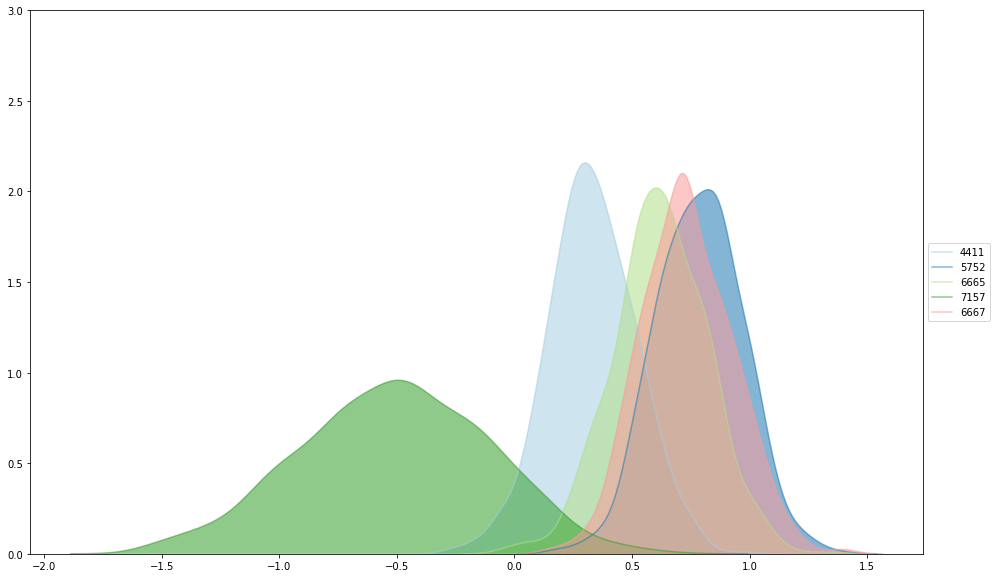

In [17]:
sns.set_palette('Paired', n_teams)
f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,3.0)
[sns.kdeplot(trace['rating_%s'%max(obs_period)][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in [4411, 5752, 6665, 7157, 6667] ]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Plot some over time ratings

C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


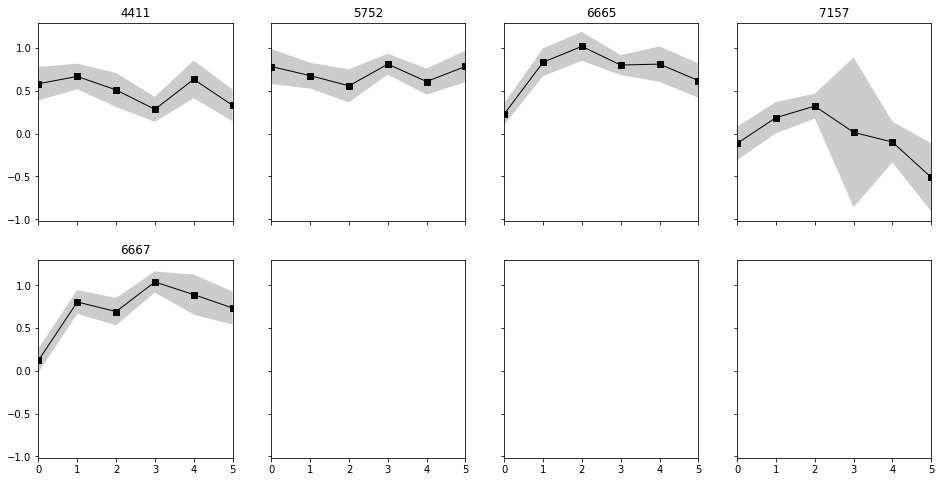

In [21]:
num_rows = int(np.ceil(len([4411, 5752, 6665, 7157, 6667])/4))
f, ax = plt.subplots(num_rows, 4, figsize=(16,8), sharex=True, sharey=True)
ax = ax.flatten()
condensed_ratings = {j: np.vstack([trace['rating_'+str(i)][:,tmap[j]] for i in range(n_periods)]).T for j in [4411, 5752, 6665, 7157, 6667]}
for i,j in enumerate([4411, 5752, 6665, 7157, 6667]):
    ax[i].set_title(j)
    sns.tsplot(condensed_ratings[j], color='black', ci='sd', ax=ax[i], marker='s', linewidth=1)